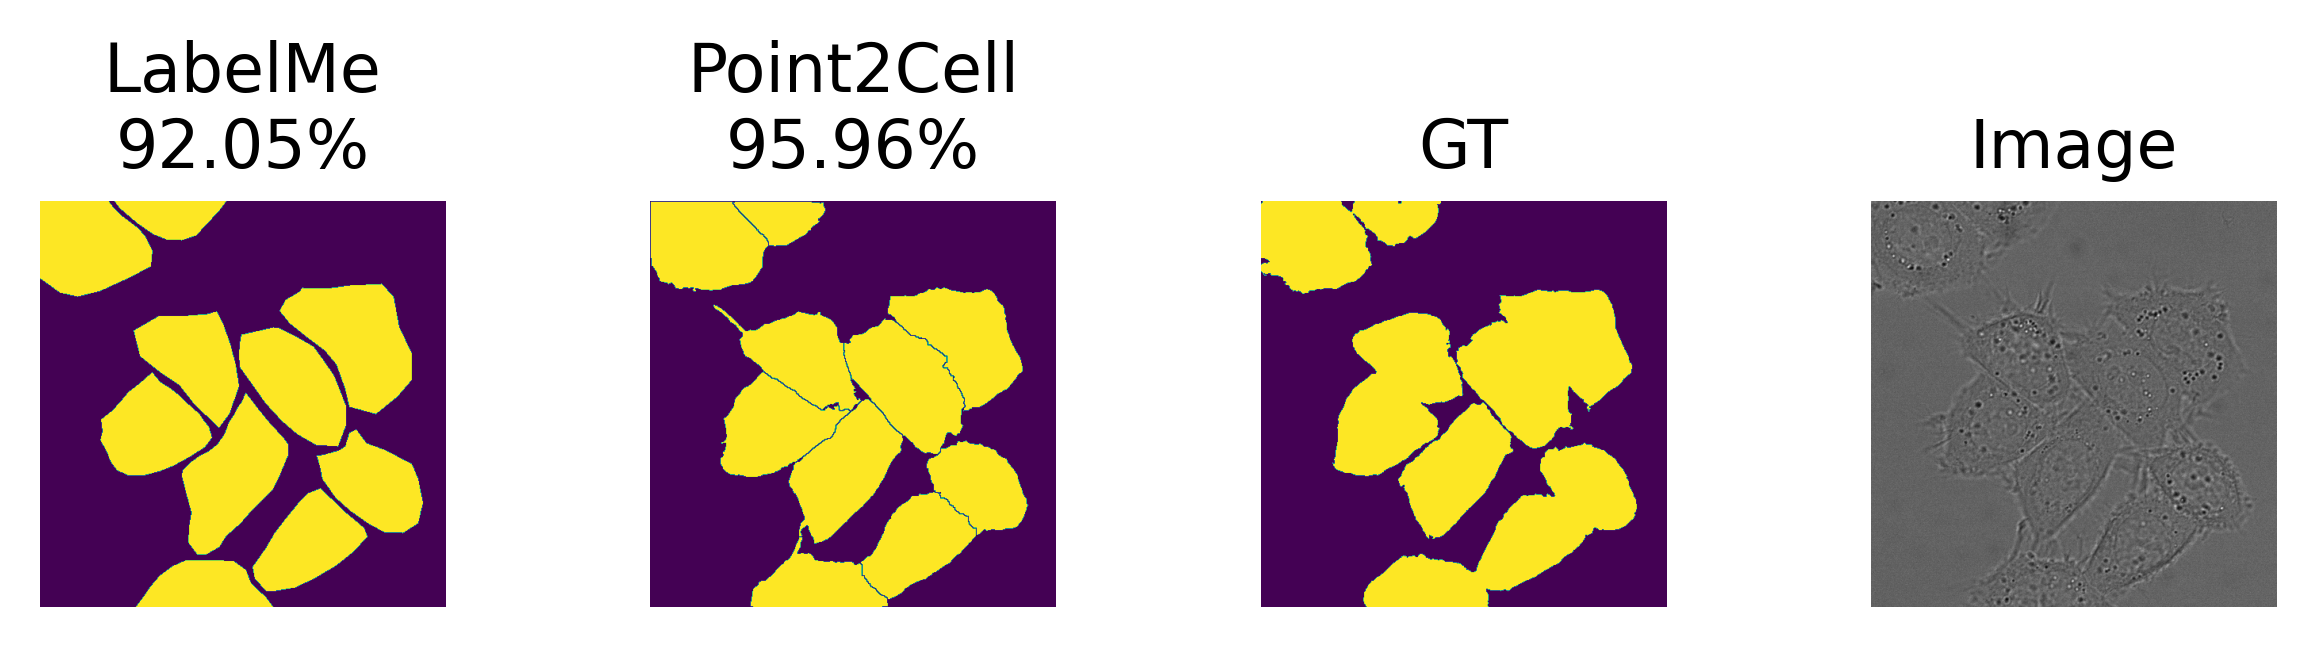

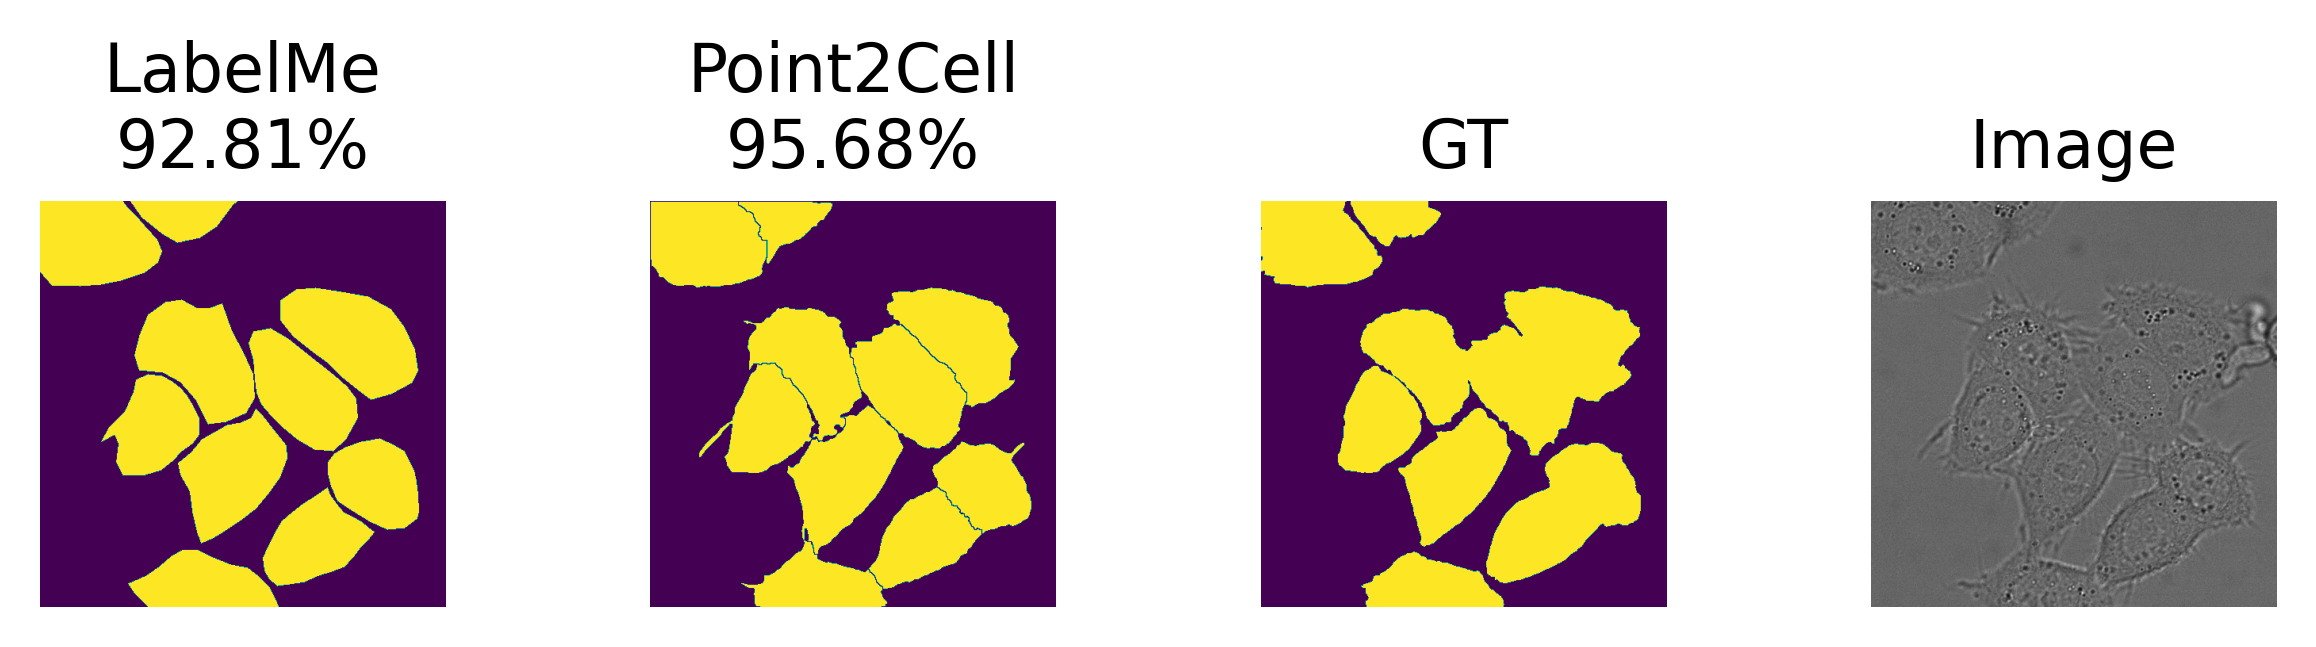

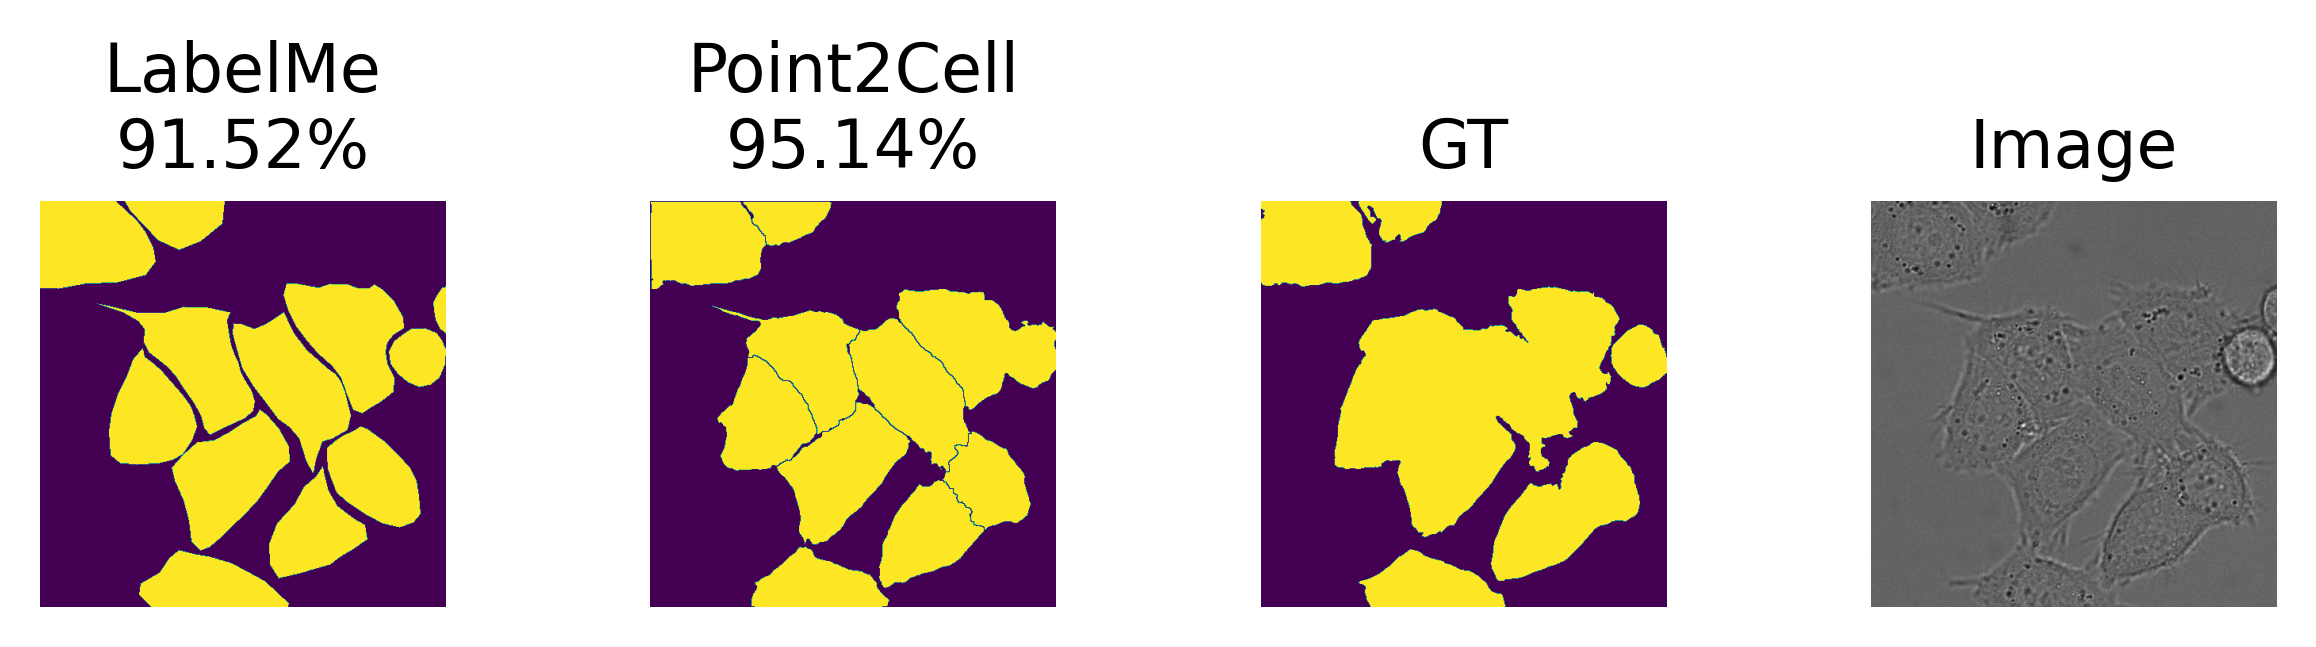

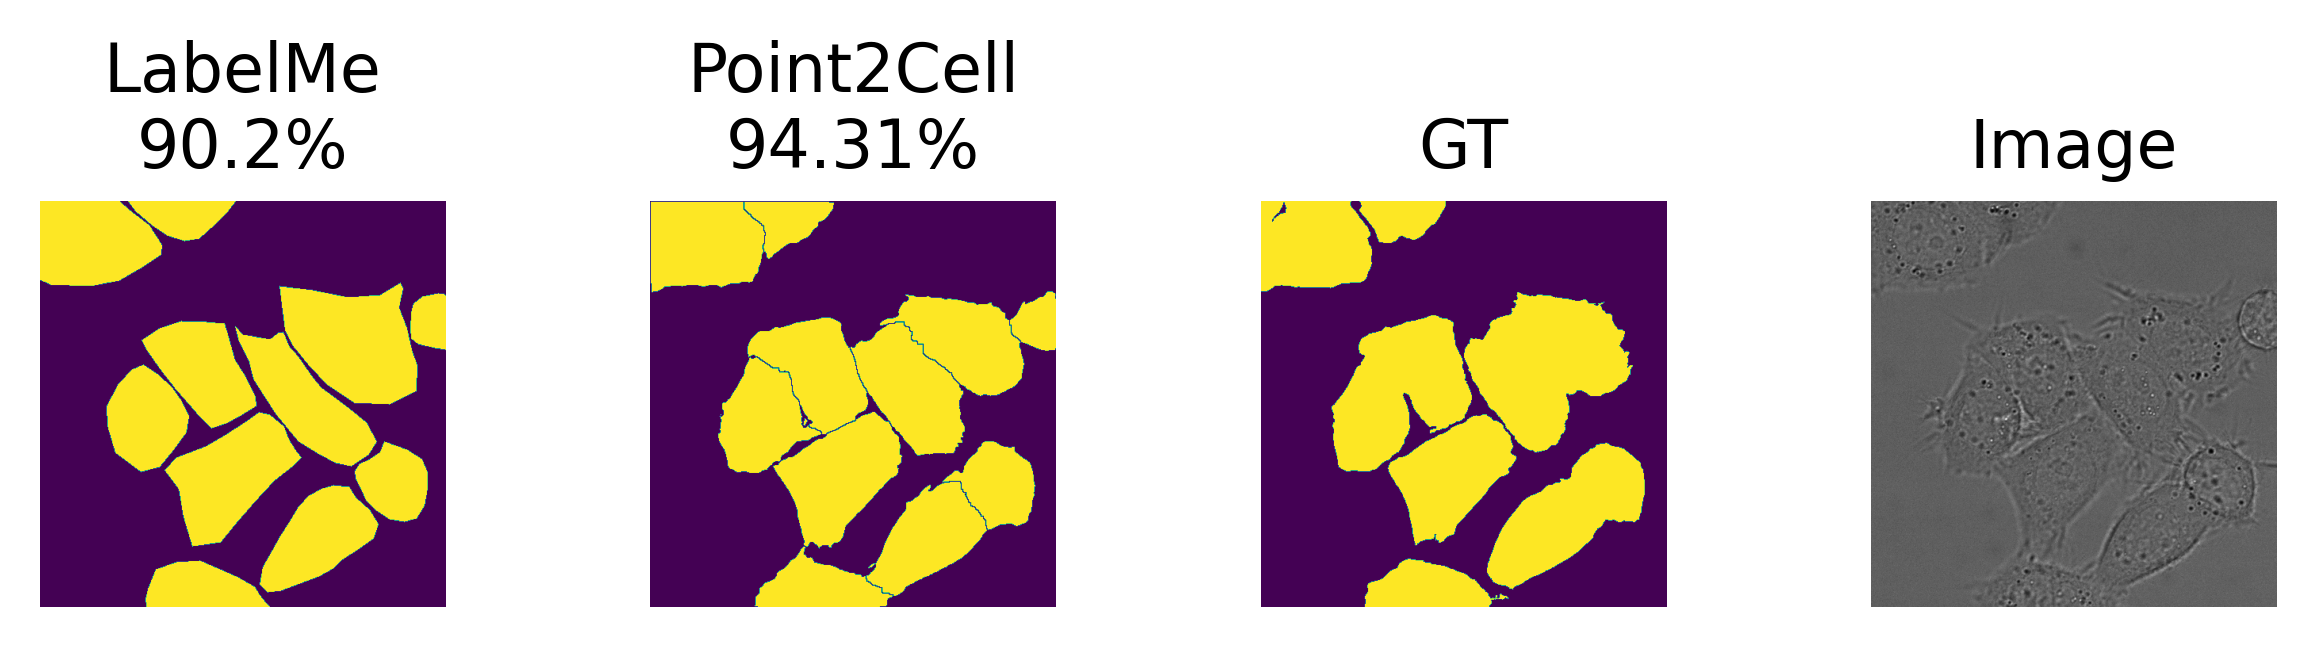

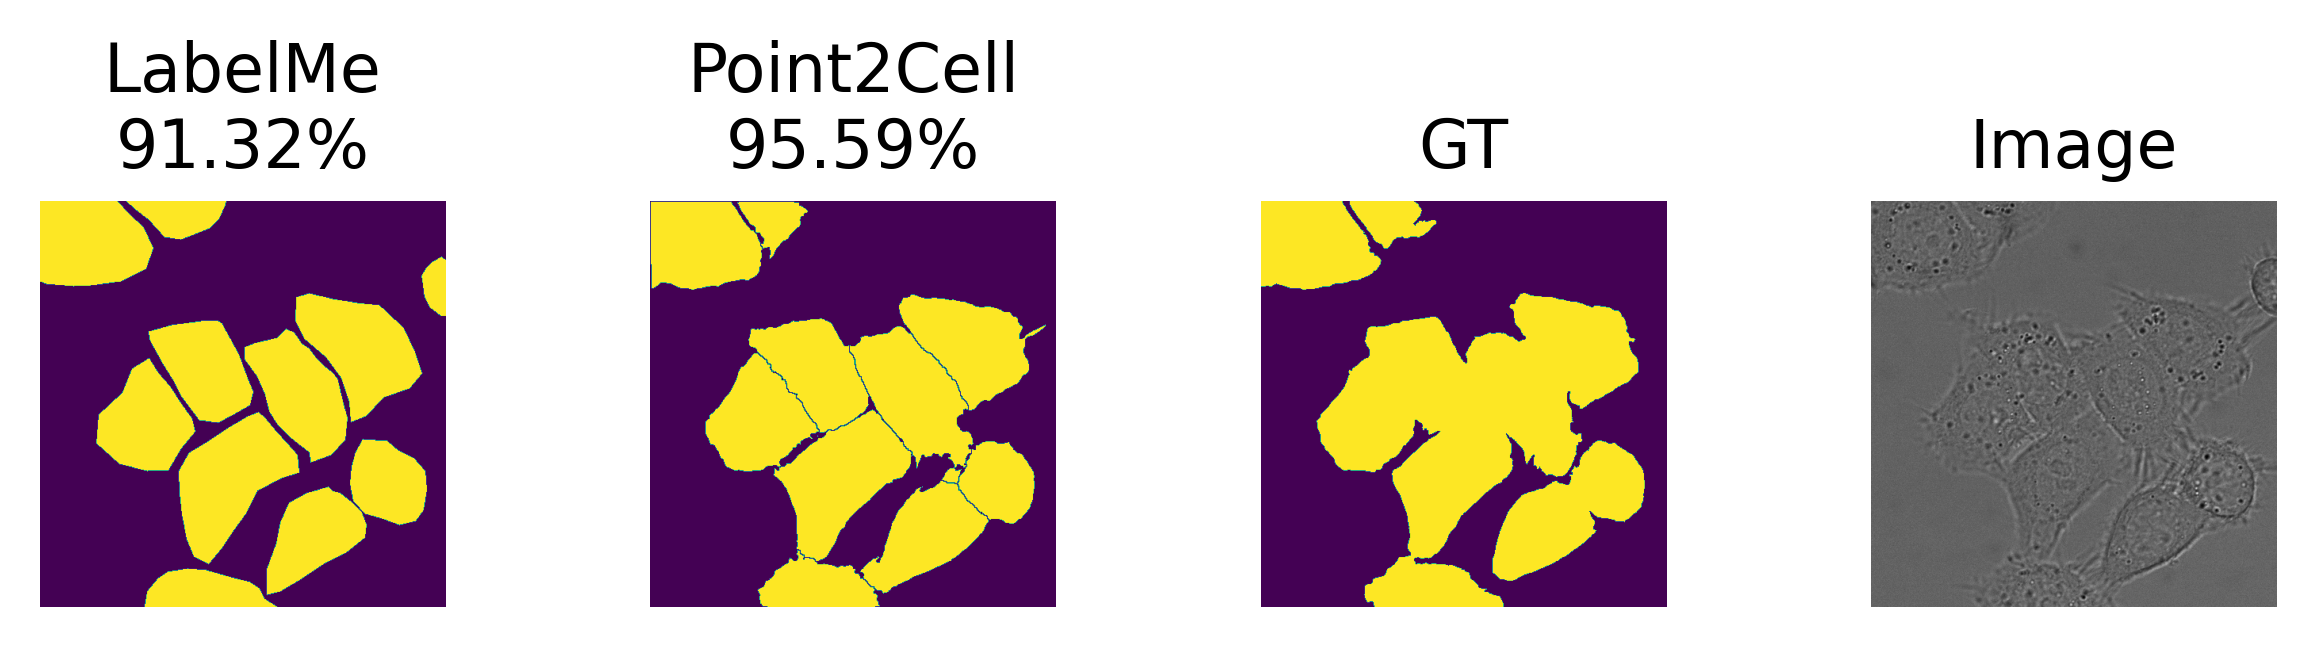

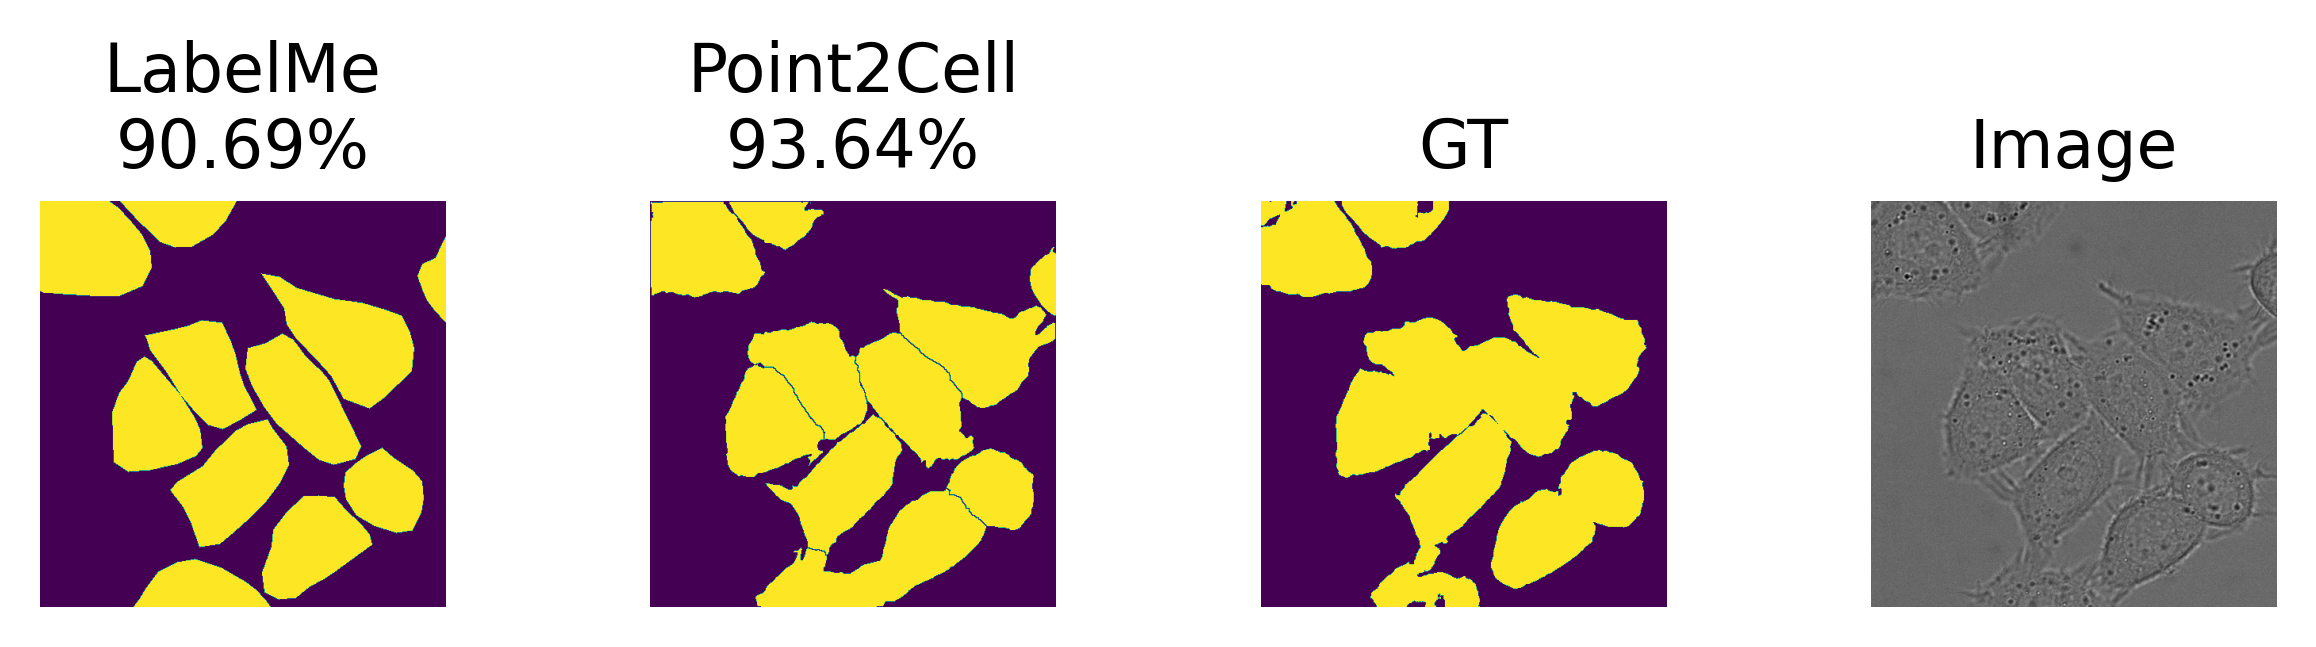

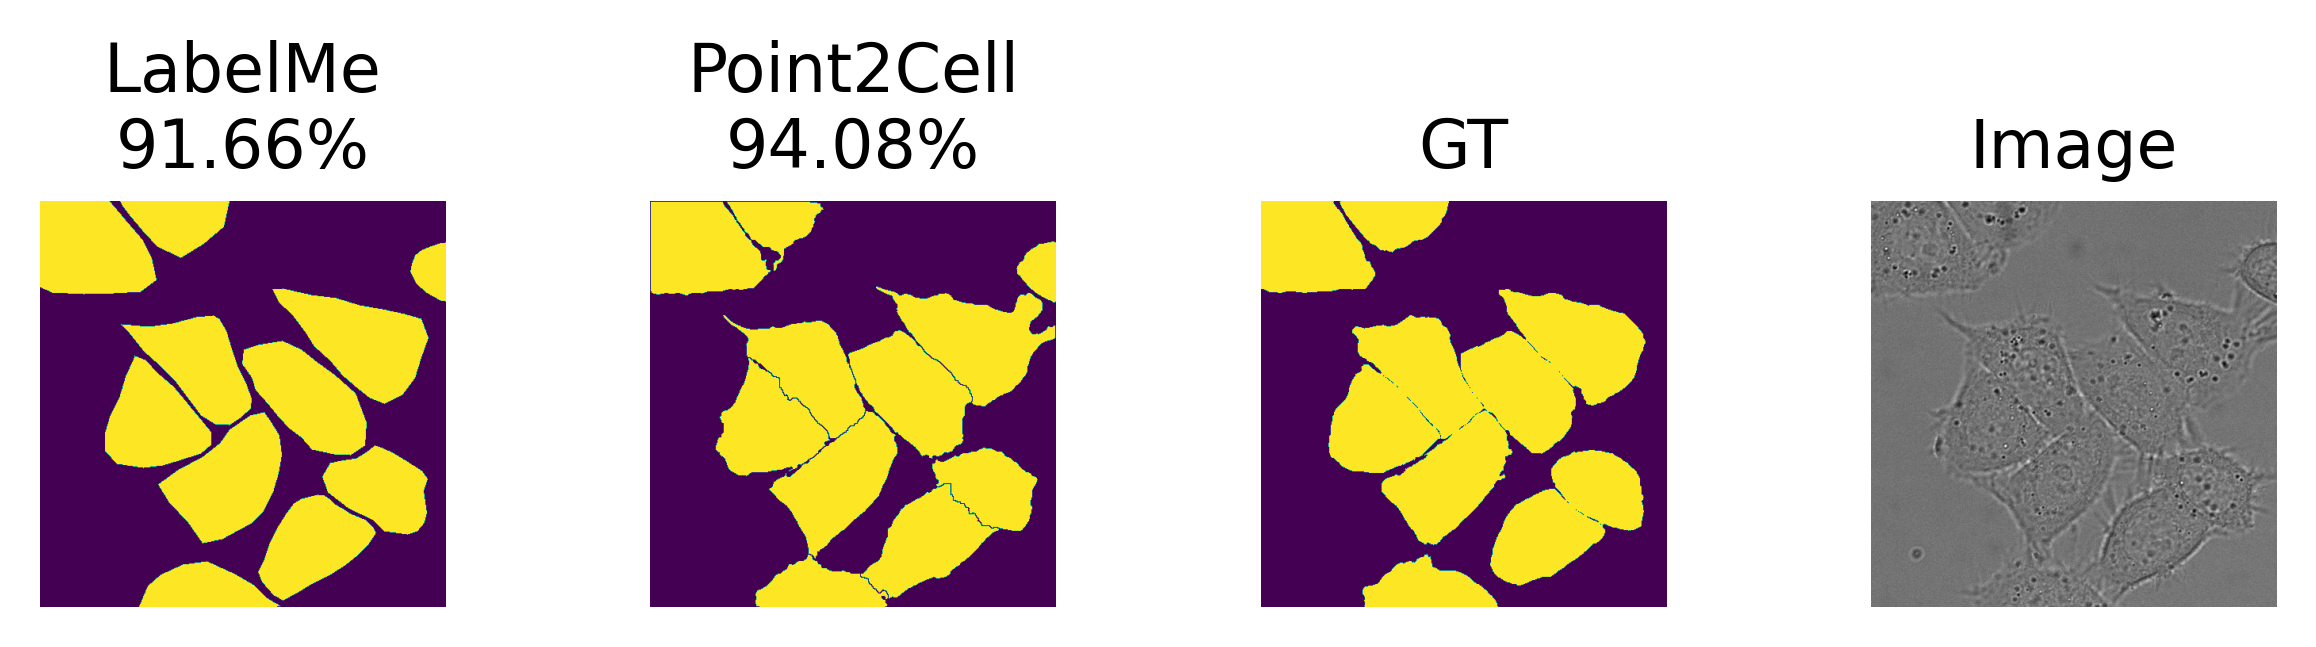

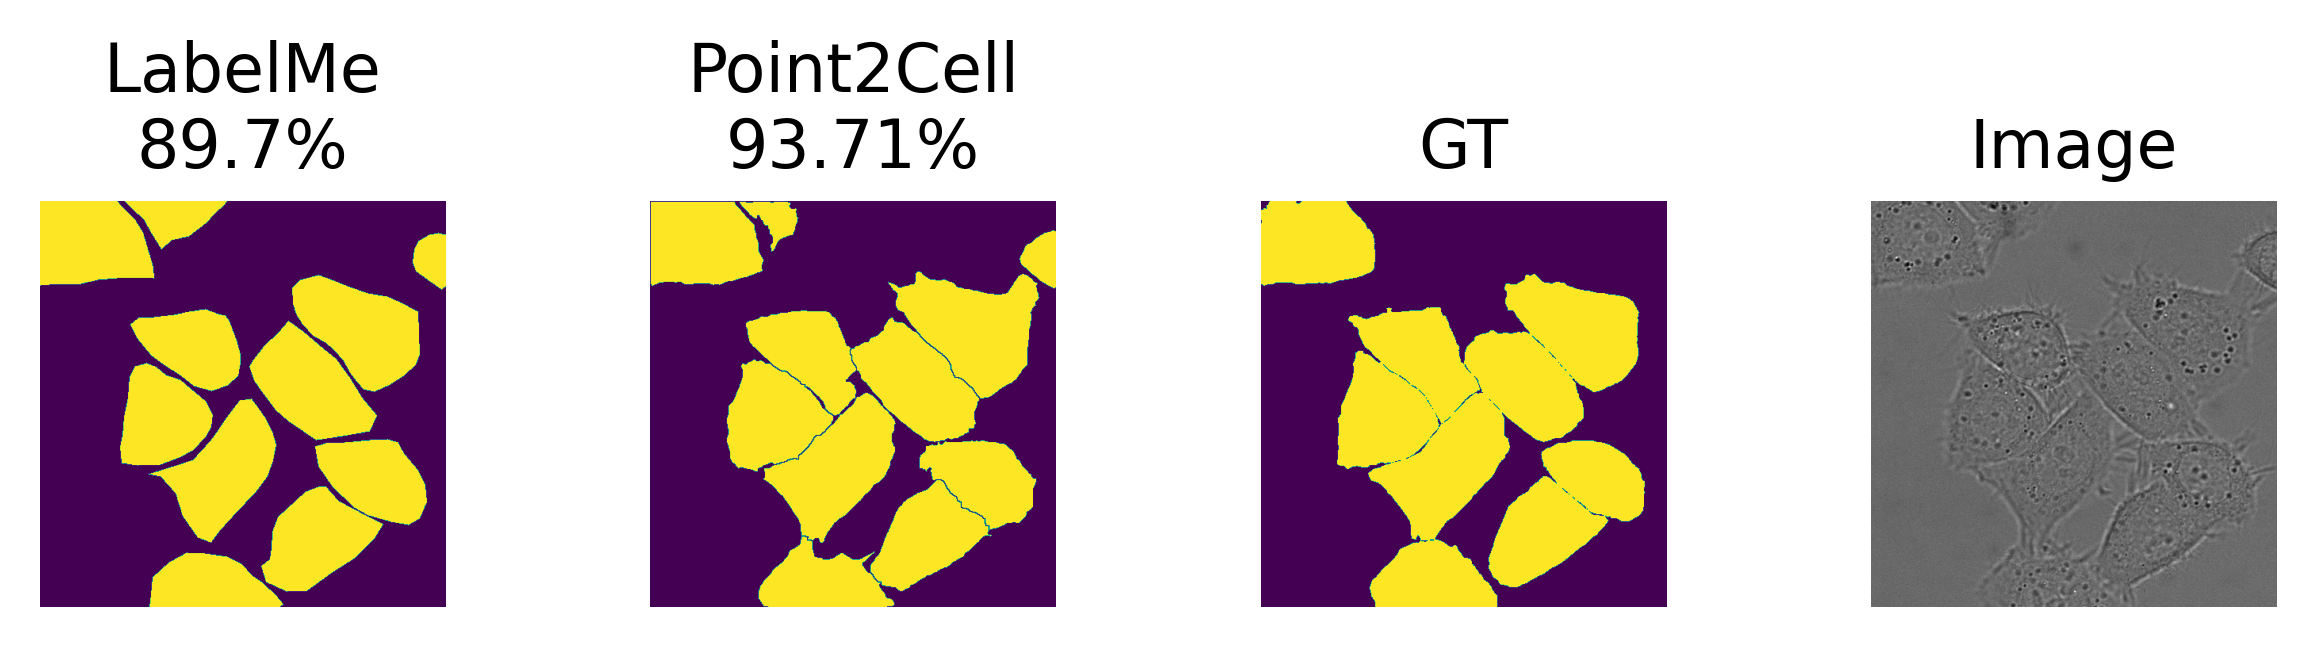

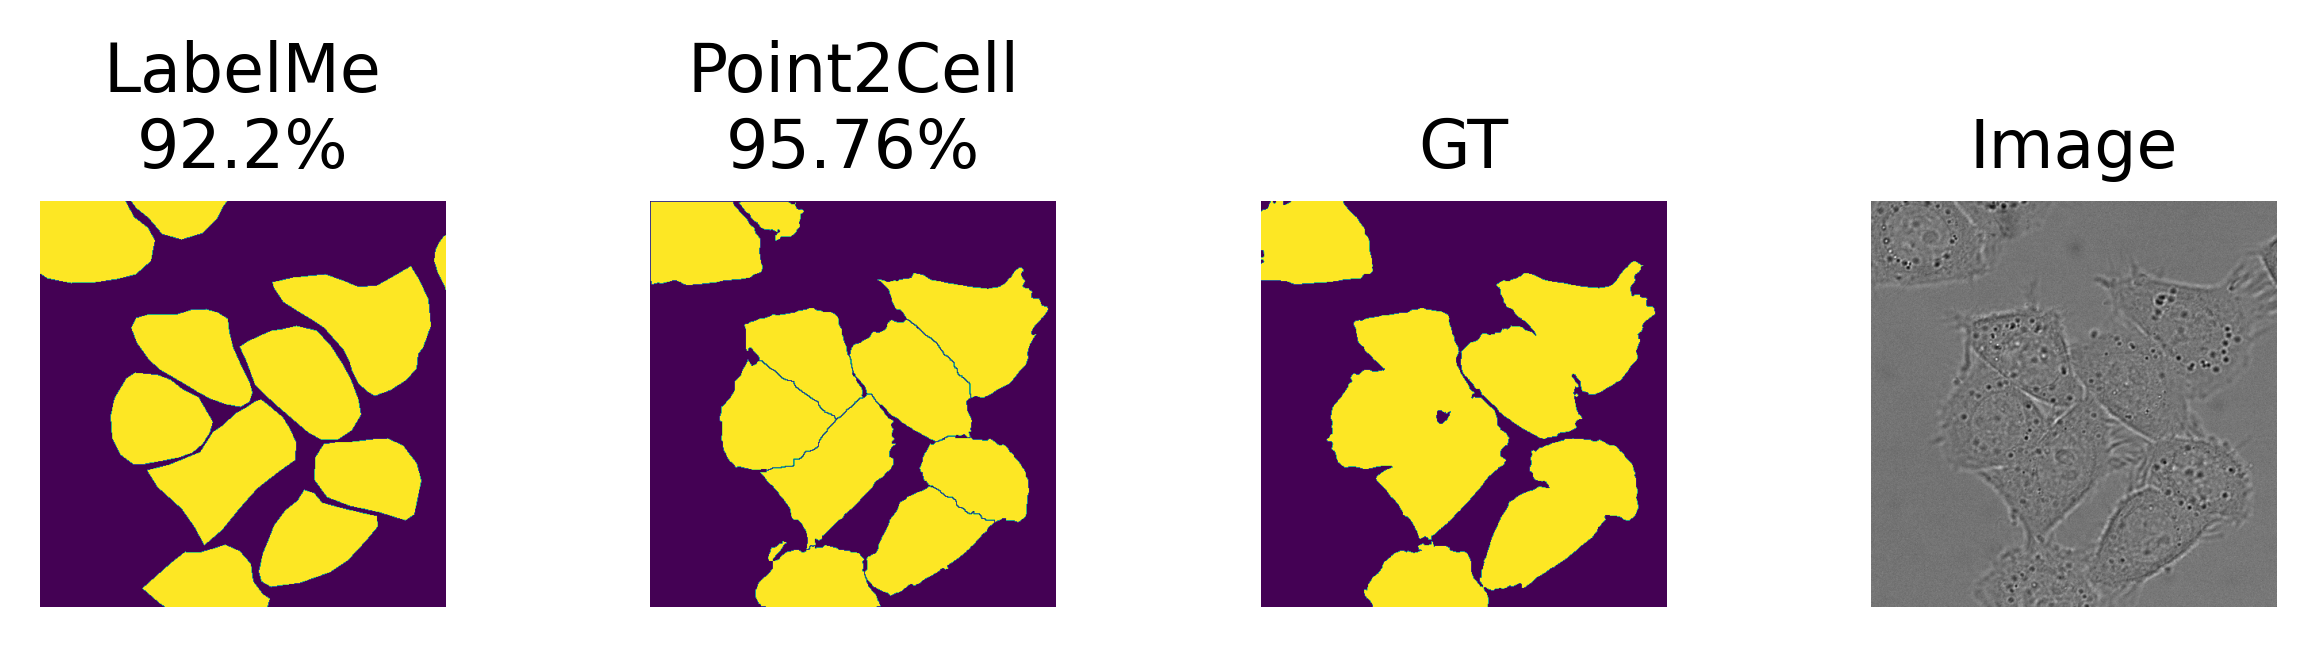

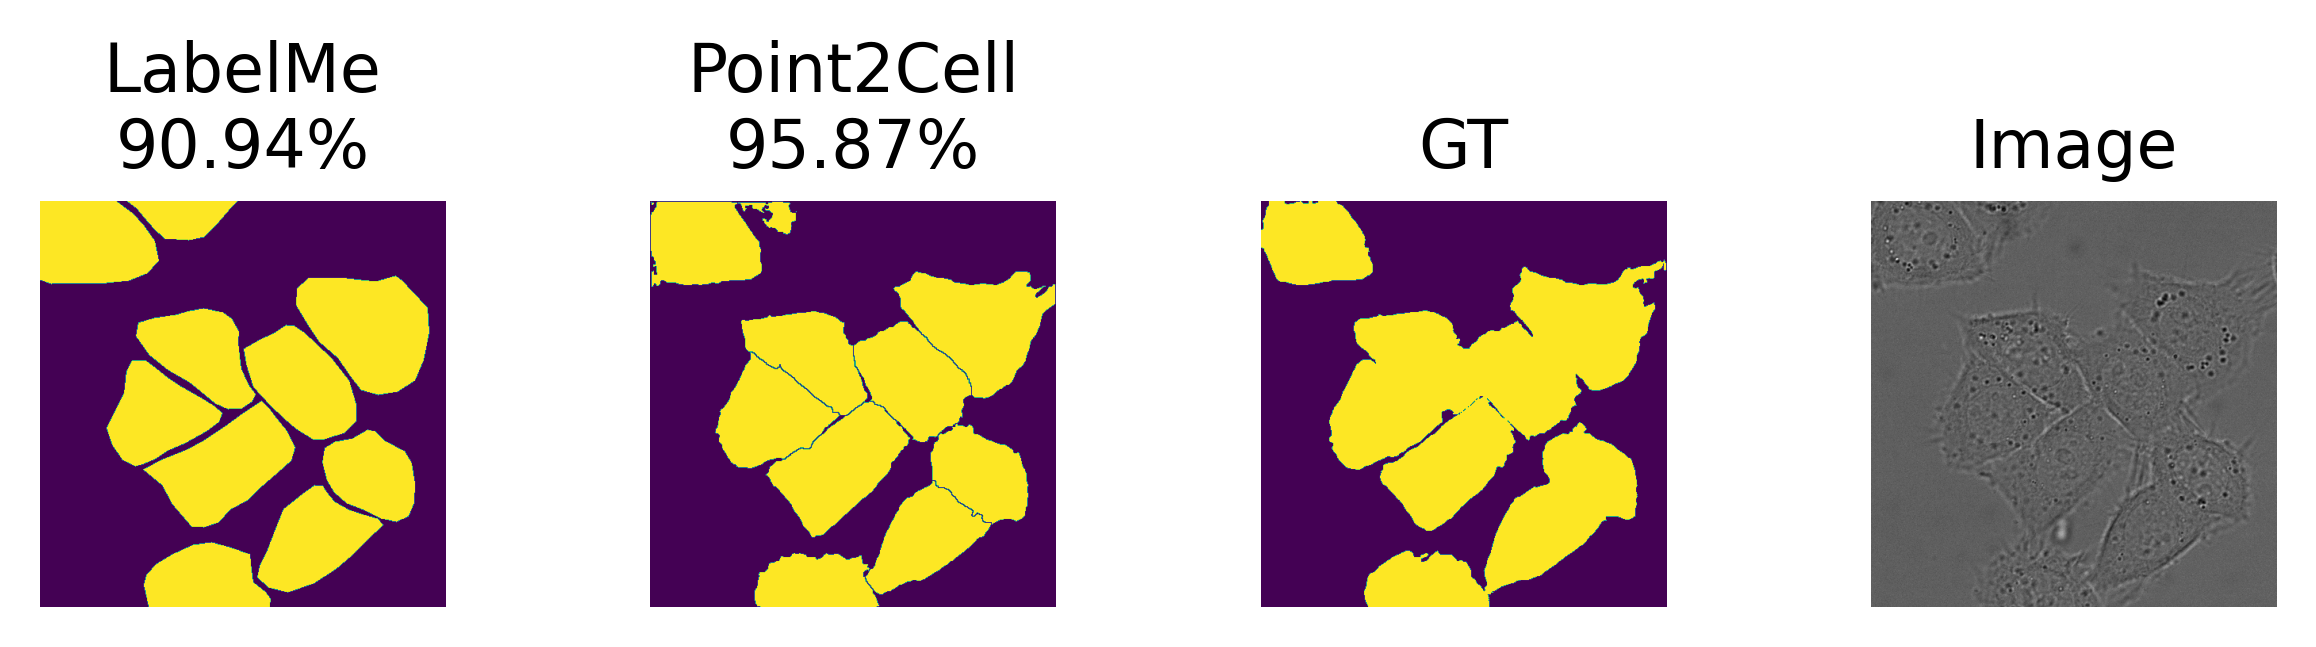

[INFO] Avergae DICE score of labelMe :
91.30900000000001%
std 0.900104993875714
[INFO] Avergae DICE score of our tool :
94.97399999999999%
std 0.8896988254460062


In [1]:
"""
Created on Mon Jan 27 14:34:22 2022
    Sorbonne Université
    Paris Brain Institute (INSERM, CNRS, Sorbonne Univeristé, AP-HP), INRIA "ARAMIS Lab"
@author: mehdi.ounissi
@email : mehdi.ounissi@icm-institue.org
         mehdi.ounissi@etu.sorbonne-universite.fr
"""
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
from natsort import natsorted
from glob import glob
import numpy as np
import json
import os


def polygons_to_mask_array(polygons, width : int = 300, height : int = 300) -> np.ndarray:
    '''
    This function takes a list of lists that contains polygon masks for each building. Example;
    
    [[x11,y11,x12,y12,...],...,[xn1,yn1,xn2,yn2,...]]
    
    The return of this function is an array of size width x height which contains a binary mask
    as defined by the list of polygons. This will be the target for our network!
    '''
    
    new_mask = Image.new('L', (width, height), 0)    
    for polygon in polygons:
        nested_lst_of_tuples = [tuple(l) for l in polygon['points']]
        ImageDraw.Draw(new_mask).polygon(nested_lst_of_tuples, outline=1, fill=1)
    mask = np.array(new_mask)
    
    return mask

annotations_dir = os.path.join('..', '..', 'dataset','hela_cells_dataset','labelme_annotation')
gt_annotations_dir = os.path.join('..', '..', 'dataset','hela_cells_dataset','DIC-C2DH-HeLa', '02_ST','SEG')
our_annotations_dir = os.path.join('..', '..', 'dataset','hela_cells_dataset','novel_annotation', 'refined_masks')
imgs_dir = os.path.join('..', '..', 'dataset','hela_cells_dataset','DIC-C2DH-HeLa', '02')

json_paths_list = natsorted(glob(os.path.join(annotations_dir, '*.json')))
gt_bn_masks_paths_list = natsorted(glob(os.path.join(gt_annotations_dir, '*.tif')))
our_bn_masks_paths_list = natsorted(glob(os.path.join(our_annotations_dir, '*.tif')))
img_paths_list = natsorted(glob(os.path.join(imgs_dir, '*.tif')))

dice_labelMe_list = []
dice_our_annot_list = []
for i in range(len(json_paths_list)):
    with open(json_paths_list[i], encoding = 'utf-8') as f:
        data = json.load(f)

    labelMe_mask = polygons_to_mask_array(data['shapes'], 512, 512)

    gt_mask = np.array(Image.open(gt_bn_masks_paths_list[i]))
    rr, cc = np.where(gt_mask>0)
    gt_mask[rr, cc] = 1

    dice_labelMe = 100* np.sum(labelMe_mask[gt_mask==1])*2.0 / (np.sum(labelMe_mask) + np.sum(gt_mask))
    dice_labelMe = float("{:.2f}".format(dice_labelMe))
    dice_labelMe_list.append(dice_labelMe)

    our_mask = np.array(Image.open(our_bn_masks_paths_list[i]))
    rr, cc = np.where(our_mask>0)
    our_mask[rr, cc] = 1

    dice_our = 100* np.sum(our_mask[gt_mask==1])*2.0 / (np.sum(our_mask) + np.sum(gt_mask))
    dice_our = float("{:.2f}".format(dice_our))
    dice_our_annot_list.append(dice_our)

    img = np.array(Image.open(img_paths_list[i]))

    # TODO :: add images
    plt.figure(dpi=400)
    plt.subplot(141)
    plt.title(f'LabelMe\n{dice_labelMe}%')
    plt.imshow(labelMe_mask)
    plt.tight_layout()
    plt.axis('off')

    plt.subplot(142)
    plt.title(f'Point2Cell\n{dice_our}%')
    plt.imshow(our_mask)
    plt.tight_layout()
    plt.axis('off')

    plt.subplot(143)
    plt.title('GT')
    plt.imshow(gt_mask)
    plt.tight_layout()
    plt.axis('off')

    plt.subplot(144)
    plt.title('Image')
    plt.imshow(img, cmap='gray')
    plt.tight_layout()
    plt.axis('off')
    plt.show()

print(f'[INFO] Avergae DICE score of labelMe :\n{np.mean(dice_labelMe_list)}%\nstd {np.std(dice_labelMe_list)}')
print(f'[INFO] Avergae DICE score of our tool :\n{np.mean(dice_our_annot_list)}%\nstd {np.std(dice_our_annot_list)}')